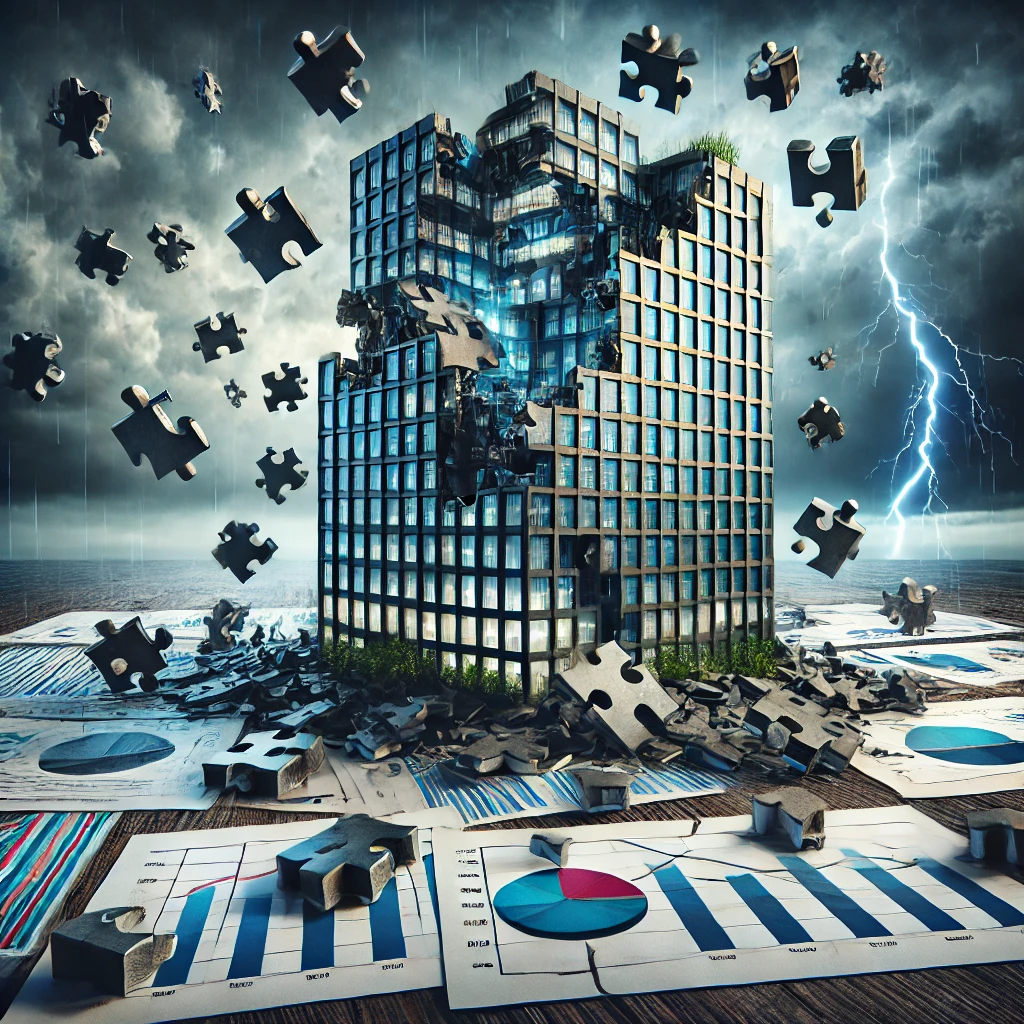

In today’s unpredictable business landscape, assessing the financial stability of companies is increasingly important. This project utilizes a robust dataset with 52 financial indicators which influencing company stability.

The project aims to forecast potential company defaults by applying machine learning techniques

Through a detailed analysis of critical financial metrics, it seeks to offer valuable insights that can help businesses proactively manage risks and avoid financial pitfalls.

In [5]:
# Basic libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns',None)

# Other packages
from sklearn.impute import KNNImputer
from scipy.stats import f_oneway
from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler

# Model Building & Evaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# Warnings
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Load the data

dataset = pd.read_csv('Company data.csv')

In [7]:
# Shape

print(f'Data has {dataset.shape[0]} Rows & {dataset.shape[1]} Columns.')

Data has 3541 Rows & 52 Columns.


In [8]:
# Dataset Preview

dataset.head()

Num  Networth Next Year  Total assets  Net worth  Total income  \
0    1              8890.6       17512.3     7093.2       24965.2   
1    2               394.3         941.0      351.5        1527.4   
2    3                92.2         232.8      100.6         477.3   
3    4                 2.7           2.7        2.7           NaN   
4    5               109.0         478.5      107.6        1580.5   

   Change in stock  Total expenses  Profit after tax  PBDITA     PBT  \
0            235.8         23657.8            1543.2  2860.2  2417.2   
1             42.7          1454.9             115.2   283.0   188.4   
2             -5.2           478.7              -6.6     5.8    -6.6   
3              NaN             NaN               NaN     NaN     NaN   
4            -17.0          1558.0               5.5    31.0     6.3   

   Cash profit  PBDITA as % of total income  PBT as % of total income  \
0       1872.8                        11.46                      9.68   
1        158.6                        18.53                     12.33   
2          0.3                         1.22                     -1.38   
3          NaN                         0.00                      0.00   
4         11.9                         1.96                      0.40   

   PAT as % of total income  Cash profit as % of total income  \
0                      6.18                              7.50   
1                      7.54                             10.38   
2                     -1.38                              0.06   
3                      0.00                              0.00   
4                      0.35                              0.75   

   PAT as % of net worth    Sales  Income from financial services  \
0                  23.78  24458.0                           158.0   
1                  38.08   1504.3                             4.0   
2                  -6.35    475.6                             1.5   
3                   0.00      NaN                             NaN   
4                   5.25   1575.1                             3.9   

   Other income  Total capital  Reserves and funds  \
0         297.2          423.8              6822.8   
1          15.9          115.5               257.8   
2           0.2           81.4                19.2   
3           NaN            0.5                 2.2   
4           0.9            6.2               161.8   

   Deposits (accepted by commercial banks)  Borrowings  \
0                                      NaN        14.9   
1                                      NaN       272.5   
2                                      NaN        35.4   
3                                      NaN         NaN   
4                                      NaN       193.1   

   Current liabilities & provisions  Deferred tax liability  \
0                            9965.9                   284.9   
1                             210.0                    85.2   
2                              96.8                     NaN   
3                               NaN                     NaN   
4                             112.8                     4.6   

   Shareholders funds  Cumulative retained profits  Capital employed  TOL/TNW  \
0              7093.2                       6263.3            7108.1     1.33   
1               351.5                        247.4             624.0     1.23   
2               100.6                         32.4             136.0     1.44   
3                 2.7                          2.2               2.7     0.00   
4               107.6                         82.7             300.7     2.83   

   Total term liabilities / tangible net worth  \
0                                         0.00   
1                                         0.34   
2                                         0.29   
3                                         0.00   
4                                         1.59   

   Contingent liabilities / Net worth (%)  Contingent liabilities  \


In [9]:
# Information

total_col = len(dataset.columns)
num_col = []
cat_col = []

for feature in dataset:
  if dataset[feature].dtypes == 'O':
    cat_col.append(feature)
  else:
    num_col.append(feature)

print('Total Number of Features:- ', total_col)
print('-'*40)
print('Number of Numerical Features:- ', len(num_col))
print('Number of Categorical Features:- ', len(cat_col))

Total Number of Features:-  52
----------------------------------------
Number of Numerical Features:-  52
Number of Categorical Features:-  0


In [10]:
# Creating binary target variable using 'Networth_Next_Year'

dataset['Default'] = np.where(dataset['Networth Next Year']>0,0,1)
dataset.drop(['Num','Networth Next Year'], axis=1, inplace=True)

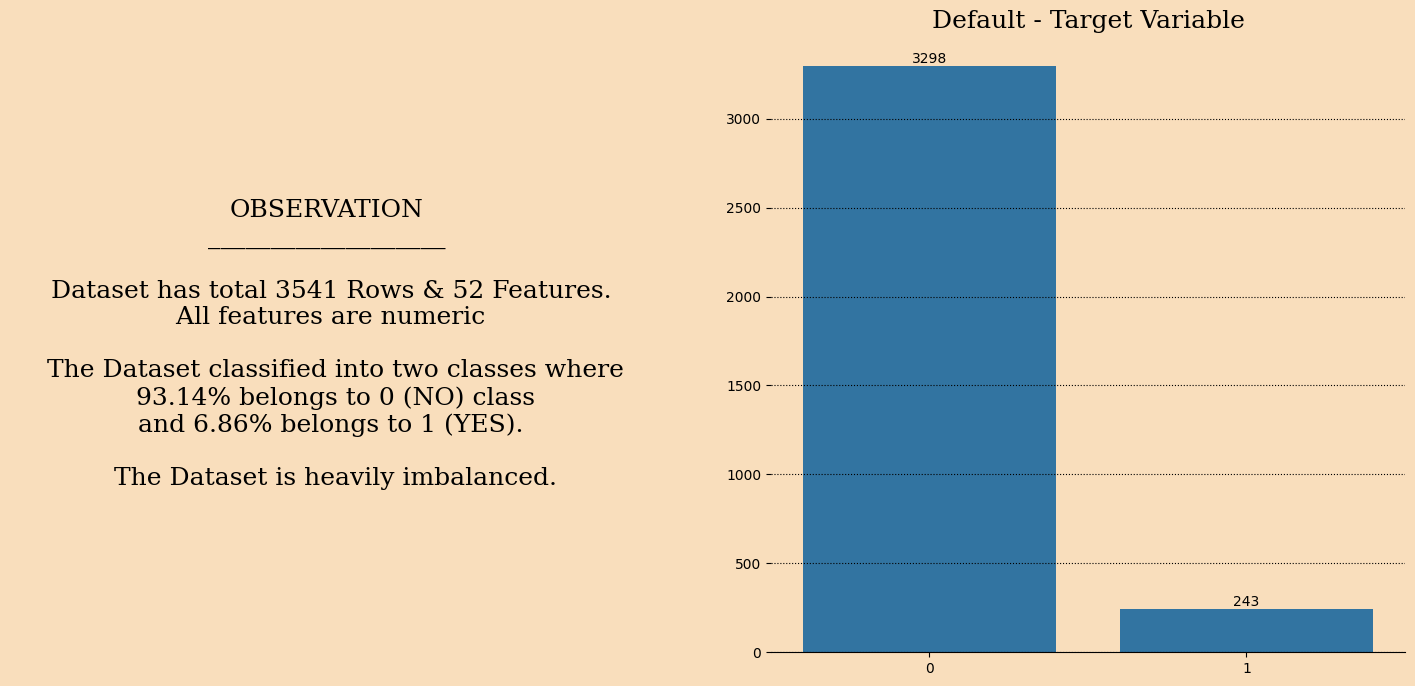

In [11]:
# Creating plot structure
fig, axes = plt.subplots(1,2, figsize=(18,8))

# Adding color preference
bg_color = '#f9debc'
fig.set_facecolor(bg_color)
axes[0].set_facecolor(bg_color)
axes[1].set_facecolor(bg_color)

# Plot graph
ax = sns.countplot(x=dataset['Default'], ax=axes[1])
ax.bar_label(ax.containers[0])
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_title('Default - Target Variable', size=18, family='serif')
axes[1].grid(axis='y', ls=':', color='#000000')

max, min = round(dataset['Default'].value_counts(normalize=True)*100,2)
axes[0].text(0.5,0.5, f'OBSERVATION\n___________________\n\n Dataset has\
 total 3541 Rows & 52 Features.\n All features are numeric\n\n\
  The Dataset classified into two classes where\n\
  {max}% belongs to 0 (NO) class\n and {min}% belongs to 1 (YES).\n\n\
  The Dataset is heavily imbalanced.',
             ha='center',va='center',size=18,family='serif')

# Removing spines & axis
axes[0].xaxis.set_visible(False)
axes[0].yaxis.set_visible(False)
for position in ['left','right','top','bottom']:
  for i in range(2):
    if position=='bottom' and i==1:
      continue
    else:
      axes[i].spines[position].set_visible(False)

In [12]:
# All feature name

dataset.columns

Index(['Total assets', 'Net worth', 'Total income', 'Change in stock',
       'Total expenses', 'Profit after tax', 'PBDITA', 'PBT', 'Cash profit',
       'PBDITA as % of total income', 'PBT as % of total income',
       'PAT as % of total income', 'Cash profit as % of total income',
       'PAT as % of net worth', 'Sales', 'Income from financial services',
       'Other income', 'Total capital', 'Reserves and funds',
       'Deposits (accepted by commercial banks)', 'Borrowings',
       'Current liabilities & provisions', 'Deferred tax liability',
       'Shareholders funds', 'Cumulative retained profits', 'Capital employed',
       'TOL/TNW', 'Total term liabilities / tangible net worth',
       'Contingent liabilities / Net worth (%)', 'Contingent liabilities',
       'Net fixed assets', 'Investments', 'Current assets',
       'Net working capital', 'Quick ratio (times)', 'Current ratio (times)',
       'Debt to equity ratio (times)', 'Cash to current liabilities (times)',
       'C

In [13]:
# Modify feature names for ease

dataset.columns = dataset.columns.str.replace(' ', '_').str.replace('(','').\
  str.replace(')','').str.replace('/','_to_').str.replace('%','perc').\
  str.replace('__','_')

dataset.columns

Index(['Total_assets', 'Net_worth', 'Total_income', 'Change_in_stock',
       'Total_expenses', 'Profit_after_tax', 'PBDITA', 'PBT', 'Cash_profit',
       'PBDITA_as_perc_of_total_income', 'PBT_as_perc_of_total_income',
       'PAT_as_perc_of_total_income', 'Cash_profit_as_perc_of_total_income',
       'PAT_as_perc_of_net_worth', 'Sales', 'Income_from_financial_services',
       'Other_income', 'Total_capital', 'Reserves_and_funds',
       'Deposits_accepted_by_commercial_banks', 'Borrowings',
       'Current_liabilities_&_provisions', 'Deferred_tax_liability',
       'Shareholders_funds', 'Cumulative_retained_profits', 'Capital_employed',
       'TOL_to_TNW', 'Total_term_liabilities_to_tangible_net_worth',
       'Contingent_liabilities_to_Net_worth_perc', 'Contingent_liabilities',
       'Net_fixed_assets', 'Investments', 'Current_assets',
       'Net_working_capital', 'Quick_ratio_times', 'Current_ratio_times',
       'Debt_to_equity_ratio_times', 'Cash_to_current_liabilities_times'

# Checking Missing Values

In [14]:
miss_gt25 = []
miss_lt25 = []

for feature in dataset:
  if dataset[feature].isnull().sum() > 0:
    if dataset[feature].isnull().mean() >= 0.25:
      miss_gt25.append(feature)
    else:
      miss_lt25.append(feature)

print(f'{len(miss_gt25)} features are having more than 25% missing values')
print('-'*50)
print(f'{len(miss_lt25)} features are having less than 25% missing values')

7 features are having more than 25% missing values
--------------------------------------------------
31 features are having less than 25% missing values


In [15]:
# Features with >25% missing values

pd.DataFrame({'% Missing Value': dataset[miss_gt25].isnull().mean()*100})

% Missing Value
Income_from_financial_services               26.404970
Other_income                                 36.571590
Deposits_accepted_by_commercial_banks       100.000000
Deferred_tax_liability                       32.194295
Contingent_liabilities                       33.549845
Investments                                  40.525275
PE_on_BSE                                    61.959898

In [16]:
# Drop the features with >25% missing values

dataset.drop(dataset[miss_gt25], axis=1, inplace=True)

In [17]:
# Features with <25% missing values

pd.DataFrame({'% Missing Value': dataset[miss_lt25].isnull().mean()*100})

% Missing Value
Total_income                                  5.591641
Change_in_stock                              12.934199
Total_expenses                                3.925445
Profit_after_tax                              3.699520
PBDITA                                        3.699520
PBT                                           3.699520
Cash_profit                                   3.699520
PBDITA_as_perc_of_total_income                1.920361
PBT_as_perc_of_total_income                   1.920361
PAT_as_perc_of_total_income                   1.920361
Cash_profit_as_perc_of_total_income           1.920361
Sales                                         7.314318
Total_capital                                 0.112962
Reserves_and_funds                            2.400452
Borrowings                                   10.336063
Current_liabilities_&_provisions              2.711099
Cumulative_retained_profits                   1.073143
Net_fixed_assets                              3.332392
Current_assets                                1.863880
Net_working_capital                           0.903700
Quick_ratio_times                             2.626377
Current_ratio_times                           2.626377
Cash_to_current_liabilities_times             2.626377
Cash_to_average_cost_of_sales_per_day         2.400452
Creditors_turnover                            9.404123
Debtors_turnover                              9.262920
Finished_goods_turnover                      20.898051
WIP_turnover                                 18.073990
Raw_material_turnover                        10.194860
Shares_outstanding                           19.542502
Equity_face_value                            19.542502

In [18]:
# Impute values on features <25% missing values

imputer = KNNImputer()
dataset[miss_lt25] = imputer.fit_transform(dataset[miss_lt25])

In [19]:
print('There is no missing value' if dataset.isnull().sum().sum()==0
      else f'There is {dataset.isnull().sum().sum()} missing values')

There is no missing value


# Statistical Tests

In [20]:
num = []
for i in dataset:
  if dataset[i].dtypes != 'O' and i != 'Default':
    num.append(i)

In [21]:
# Anova Test

columns_kept = []
for i in num:
  a = list(dataset[i])
  b = list(dataset['Default'])

  group_0 = [value for value, group in zip(a,b) if group==0]
  group_1 = [value for value, group in zip(a,b) if group==1]

  f_stats, p_val = f_oneway(group_0, group_1)
  if p_val <= 0.05:
    columns_kept.append(i)

In [25]:
# List of significant features

columns_kept

['PBDITA_as_perc_of_total_income',
 'PBT_as_perc_of_total_income',
 'PAT_as_perc_of_total_income',
 'Cash_profit_as_perc_of_total_income',
 'PAT_as_perc_of_net_worth',
 'TOL_to_TNW',
 'Total_term_liabilities_to_tangible_net_worth',
 'Contingent_liabilities_to_Net_worth_perc',
 'Debt_to_equity_ratio_times',
 'Cash_to_average_cost_of_sales_per_day',
 'Shares_outstanding',
 'Equity_face_value',
 'EPS',
 'Adjusted_EPS']

In [26]:
# Only considering statistically significant features

final_df = dataset[columns_kept + ['Default']]

print(f'Final Dataset has {final_df.shape[0]} Rows & {final_df.shape[1]} Columns.')

Final Dataset has 3541 Rows & 15 Columns.


# Checking Outliers

In [27]:
# Checking number of outliers per columns

q1 = final_df.quantile(0.25)
q3 = final_df.quantile(0.75)
iqr = q3 - q1
ul = q3 + 1.5 * iqr
ll = q1 - 1.5 * iqr

((final_df > ul) | (final_df < ll)).sum().iloc[:-1].to_frame().\
  rename(columns={0:'Number of Outliers'})

Number of Outliers
PBDITA_as_perc_of_total_income                               296
PBT_as_perc_of_total_income                                  467
PAT_as_perc_of_total_income                                  523
Cash_profit_as_perc_of_total_income                          367
PAT_as_perc_of_net_worth                                     344
TOL_to_TNW                                                   335
Total_term_liabilities_to_tangible_net_worth                 328
Contingent_liabilities_to_Net_worth_perc                     391
Debt_to_equity_ratio_times                                   310
Cash_to_average_cost_of_sales_per_day                        488
Shares_outstanding                                           508
Equity_face_value                                            779
EPS                                                          540
Adjusted_EPS                                                 582

In [28]:
# Capping method to treat outliers

def outlier_treatment(col):
  q1 = final_df[col].quantile(0.25)
  q3 = final_df[col].quantile(0.75)
  iqr = q3 - q1
  ul = q3 + 1.5 * iqr
  ll = q1 - 1.5 * iqr

  final_df[col] = np.where(final_df[col]>ul,ul,
                                 np.where(final_df[col]<ll,ll,
                                          final_df[col]))

In [29]:
for feature in final_df.columns:
  if feature != 'Default':
    outlier_treatment(feature)

In [30]:
sum_outlier = ((final_df.iloc[:,:-1] > ul.iloc[:-1]) | (final_df.iloc[:,:-1] < ll.iloc[:-1])).sum().sum()
print('There is no Outlier' if sum_outlier==0 else f'There are {sum_outlier} Outliers in Dataset.')

There is no Outlier


# Split data into Dependent & Independent

In [31]:
# List of total columns

final_df.columns

Index(['PBDITA_as_perc_of_total_income', 'PBT_as_perc_of_total_income',
       'PAT_as_perc_of_total_income', 'Cash_profit_as_perc_of_total_income',
       'PAT_as_perc_of_net_worth', 'TOL_to_TNW',
       'Total_term_liabilities_to_tangible_net_worth',
       'Contingent_liabilities_to_Net_worth_perc',
       'Debt_to_equity_ratio_times', 'Cash_to_average_cost_of_sales_per_day',
       'Shares_outstanding', 'Equity_face_value', 'EPS', 'Adjusted_EPS',
       'Default'],
      dtype='object')

In [32]:
# x = Independent Features
# y = Dependent Feature

x = final_df.iloc[:,:-1]
y = final_df.iloc[:,-1]

In [33]:
# Independent Features

pd.DataFrame(x).columns

Index(['PBDITA_as_perc_of_total_income', 'PBT_as_perc_of_total_income',
       'PAT_as_perc_of_total_income', 'Cash_profit_as_perc_of_total_income',
       'PAT_as_perc_of_net_worth', 'TOL_to_TNW',
       'Total_term_liabilities_to_tangible_net_worth',
       'Contingent_liabilities_to_Net_worth_perc',
       'Debt_to_equity_ratio_times', 'Cash_to_average_cost_of_sales_per_day',
       'Shares_outstanding', 'Equity_face_value', 'EPS', 'Adjusted_EPS'],
      dtype='object')

In [34]:
# Independent Features

pd.DataFrame(y).columns

Index(['Default'], dtype='object')

# Imbalance Treatment

In [35]:
ros = RandomOverSampler()
x_over, y_over = ros.fit_resample(x, y)

In [36]:
print(f'Original Data:- {y.value_counts()}')
print('-'*20)
print(f'After OverSampling Data:- {y_over.value_counts()}')

Original Data:- Default
0    3298
1     243
Name: count, dtype: int64
--------------------
After OverSampling Data:- Default
0    3298
1    3298
Name: count, dtype: int64


# Split data into Training & Validation



In [37]:
x_train, x_test, y_train, y_test = train_test_split(x_over, y_over, test_size=0.25, random_state=42, stratify=y_over)

In [38]:
print(y_train.value_counts())
print('-'*30)
print(y_test.value_counts())

Default
1    2474
0    2473
Name: count, dtype: int64
------------------------------
Default
0    825
1    824
Name: count, dtype: int64


In [39]:
print(f'Training Shape:- {x_train.shape}-{y_train.shape}')
print(f'Testing Shape:- {x_test.shape}-{y_test.shape}')

Training Shape:- (4947, 14)-(4947,)
Testing Shape:- (1649, 14)-(1649,)


# Feature Scalling

In [40]:
# Standard Scaler

scaler = StandardScaler()
x_train_sc = pd.DataFrame(scaler.fit_transform(x_train), columns=x_train.columns)
x_test_sc = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)

In [41]:
x_train_sc.describe()

PBDITA_as_perc_of_total_income  PBT_as_perc_of_total_income  \
count                    4.947000e+03                 4.947000e+03   
mean                    -2.872621e-18                -4.883455e-17   
std                      1.000101e+00                 1.000101e+00   
min                     -1.671589e+00                -1.326226e+00   
25%                     -6.301904e-01                -9.571207e-01   
50%                     -9.519068e-02                -2.313369e-02   
75%                      5.272933e-01                 4.801438e-01   
max                      2.204635e+00                 2.173746e+00   

       PAT_as_perc_of_total_income  Cash_profit_as_perc_of_total_income  \
count                 4.947000e+03                         4.947000e+03   
mean                 -1.436310e-17                         4.452562e-17   
std                   1.000101e+00                         1.000101e+00   
min                  -1.283496e+00                        -1.488724e+00   
25%                  -1.094249e+00                        -5.155303e-01   
50%                  -9.095064e-03                        -5.220678e-02   
75%                   4.757158e-01                         5.694814e-01   
max                   2.164048e+00                         2.256386e+00   

       PAT_as_perc_of_net_worth    TOL_to_TNW  \
count              4.947000e+03  4.947000e+03   
mean              -5.601610e-17  1.055688e-16   
std                1.000101e+00  1.000101e+00   
min               -1.369644e+00 -2.352800e+00   
25%               -1.126032e+00 -8.852998e-01   
50%                2.633892e-02 -2.716545e-01   
75%                5.552774e-01  1.248329e+00   
max                2.352977e+00  1.248329e+00   

       Total_term_liabilities_to_tangible_net_worth  \
count                                  4.947000e+03   
mean                                   1.572760e-16   
std                                    1.000101e+00   
min                                   -2.346634e+00   
25%                                   -9.259566e-01   
50%                                   -3.498745e-01   
75%                                    1.363726e+00   
max                                    1.363726e+00   

       Contingent_liabilities_to_Net_worth_perc  Debt_to_equity_ratio_times  \
count                              4.947000e+03                4.947000e+03   
mean                              -8.294692e-17               -1.852840e-16   
std                                1.000101e+00                1.000101e+00   
min                               -7.617378e-01               -1.169158e+00   
25%                               -7.617378e-01               -9.605987e-01   
50%                               -6.187225e-01               -3.349208e-01   
75%                                7.171330e-01                1.312084e+00   
max                                1.778188e+00                1.312084e+00   

       Cash_to_average_cost_of_sales_per_day  Shares_outstanding  \
count                           4.947000e+03        4.947000e+03   
mean                           -9.623279e-17       -9.407833e-17   
std                             1.000101e+00        1.000101e+00   
min                            -8.588982e-01       -2.282868e+00   
25%                            -7.468234e-01       -7.044058e-01   
50%                            -4.769941e-01       -2.668433e-01   
75%                             4.049971e-01        3.262869e-01   
max                             1.930489e+00        2.081236e+00   

       Equity_face_value           EPS  Adjusted_EPS  
count             4947.0  4.947000e+03  4.947000e+03  
mean                 0.0 -4.021669e-17  3.734407e-17  
std                  0.0  1.000101e+00  1.000101e+00  
min                  0.0 -1.737071e+00 -1.661080e+00  
25%                  0.0 -2.916073e-01 -2.913639e-01  
50%                  0.0 -1.652518e-01 -1.364556e-01  
75%                  0.0  9.290561e-02  1.319163e-01

# Model Building

### RandomForest Classifier

In [42]:
# Model Building
rforest = RandomForestClassifier()
rforest.fit(x_train_sc, y_train)

# Prediction
y_pred_rf_train = rforest.predict(x_train_sc)
y_pred_rf_test = rforest.predict(x_test_sc)

# Evaluation
rf_train = accuracy_score(y_train, y_pred_rf_train)
rf_test = accuracy_score(y_test, y_pred_rf_test)
print(f'Training Accuracy:- {round(rf_train,4)*100}%')
print(f'Testing Accuracy:- {round(rf_test,4)*100}%')
print('*'*55)

print(classification_report(y_train, y_pred_rf_train))
print('-'*55)
print(classification_report(y_test, y_pred_rf_test))

Training Accuracy:- 99.82%
Testing Accuracy:- 98.61%
*******************************************************
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2473
           1       1.00      1.00      1.00      2474

    accuracy                           1.00      4947
   macro avg       1.00      1.00      1.00      4947
weighted avg       1.00      1.00      1.00      4947

-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       825
           1       0.97      1.00      0.99       824

    accuracy                           0.99      1649
   macro avg       0.99      0.99      0.99      1649
weighted avg       0.99      0.99      0.99      1649



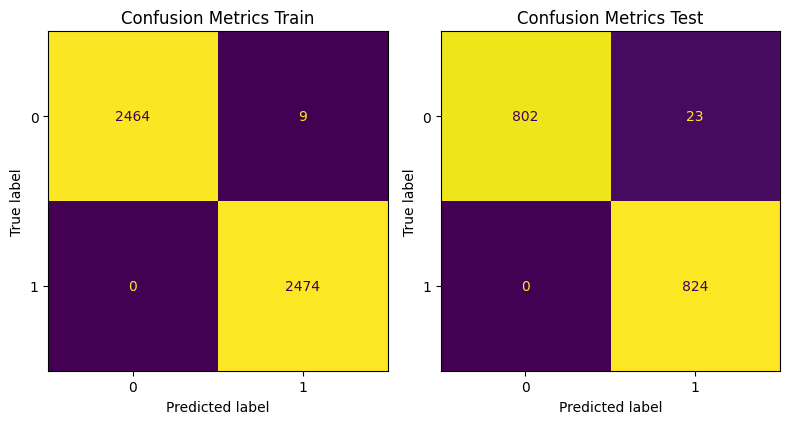

In [43]:
# Confusion Metrics

fig, axes = plt.subplots(1,2, figsize=(8,8))
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_rf_train,
                                        colorbar=False, ax=axes[0])
axes[0].set_title('Confusion Metrics Train')

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf_test,
                                        colorbar=False, ax=axes[1])
axes[1].set_title('Confusion Metrics Test')
plt.tight_layout()
plt.show()

In [44]:
# Cross Validation

cv = cross_val_score(rforest, x_train_sc, y_train, cv=5, scoring='accuracy')

print(f'Mean Accuracy:- {round(cv.mean()*100,2)}%')
print(f'Max Accuracy:- {round(cv.max()*100,2)}%')

Mean Accuracy:- 98.14%
Max Accuracy:- 98.58%


### XGBoost Classifier

In [45]:
# Model Building
xgboost = XGBClassifier()
xgboost.fit(x_train_sc, y_train)

# Prediction
y_pred_xgb_train = xgboost.predict(x_train_sc)
y_pred_xgb_test = xgboost.predict(x_test_sc)

# Evaluation
xgb_train = accuracy_score(y_train, y_pred_xgb_train)
xgb_test = accuracy_score(y_test, y_pred_xgb_test)
print(f'Training Accuracy:- {round(xgb_train,4)*100}%')
print(f'Testing Accuracy:- {round(xgb_test,4)*100}%')
print('*'*55)

print(classification_report(y_train, y_pred_xgb_train))
print('-'*55)
print(classification_report(y_test, y_pred_xgb_test))

Training Accuracy:- 99.8%
Testing Accuracy:- 98.0%
*******************************************************
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2473
           1       1.00      1.00      1.00      2474

    accuracy                           1.00      4947
   macro avg       1.00      1.00      1.00      4947
weighted avg       1.00      1.00      1.00      4947

-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       825
           1       0.96      1.00      0.98       824

    accuracy                           0.98      1649
   macro avg       0.98      0.98      0.98      1649
weighted avg       0.98      0.98      0.98      1649



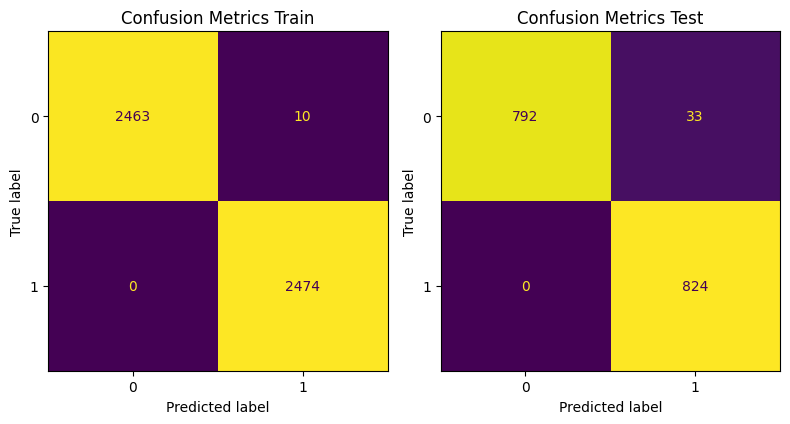

In [46]:
# Confusion Metrics

fig, axes = plt.subplots(1,2, figsize=(8,8))
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_xgb_train,
                                        colorbar=False, ax=axes[0])
axes[0].set_title('Confusion Metrics Train')

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb_test,
                                        colorbar=False, ax=axes[1])
axes[1].set_title('Confusion Metrics Test')
plt.tight_layout()
plt.show()

In [47]:
# Cross Validation

cv = cross_val_score(xgboost, x_train_sc, y_train, cv=5, scoring='accuracy')

print(f'Mean Accuracy:- {round(cv.mean()*100,2)}%')
print(f'Max Accuracy:- {round(cv.max()*100,2)}%')

Mean Accuracy:- 97.96%
Max Accuracy:- 98.28%


In [49]:
import pickle
with open('company_default.pkl','wb') as file:
    pickle.dump(rforest, file)